In [3]:
#importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow_hub as hub
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2022-07-15 15:38:02.620863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 15:38:02.620902: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# creating path to data
train_path = 'Tomatoes/train'
valid_path = 'Tomatoes/val'

In [6]:
IMG_SHAPE = 224
batch_size = 100

In [14]:
#function for data Agumentation
def data_agument():
    image_gen_train = ImageDataGenerator(rescale=1./255, rotation_range=45,\
                                         width_shift_range=.12,height_shift_range=.12,\
                                         horizontal_flip=True,zoom_range=0.15)
    return image_gen_train

In [8]:
#classes of tomatoes leaf list
classes = ['tomatoes_Bacterial_spot','tomatoes_Early_blight','tomatoes_Late_blight', 'tomatoes_Leaf_Mold',
        'tomatoes_Septoria_leaf_spot','tomatoes_Spider_mites Two-spotted_spider_mite',
        'tomatoes_Target_Spot','tomatoes_Tomato_Yellow_Leaf_Curl_Virus','tomatoes_Tomato_mosaic_virus','tomatoes_healthy']

In [15]:
#using flow from directory to load data to disk
train_data_gen = data_agument().flow_from_directory(
                batch_size=batch_size,
                directory=train_path,
                shuffle=True,
                target_size=(IMG_SHAPE,IMG_SHAPE),
                classes=classes,
                class_mode='sparse'
                )

Found 10000 images belonging to 10 classes.


In [10]:
#validation data
image_gen_val = ImageDataGenerator(rescale=1./255)

valid_data_gen = image_gen_val.flow_from_directory(
                batch_size=batch_size,
                directory=valid_path,
                shuffle=False,
                target_size=(IMG_SHAPE,IMG_SHAPE),
                classes=classes,
                class_mode='sparse'
                )

Found 1000 images belonging to 10 classes.


In [8]:
#tomatoes class labels
train_data_gen.class_indices

{'tomatoes_Bacterial_spot': 0,
 'tomatoes_Early_blight': 1,
 'tomatoes_Late_blight': 2,
 'tomatoes_Leaf_Mold': 3,
 'tomatoes_Septoria_leaf_spot': 4,
 'tomatoes_Spider_mites Two-spotted_spider_mite': 5,
 'tomatoes_Target_Spot': 6,
 'tomatoes_Tomato_Yellow_Leaf_Curl_Virus': 7,
 'tomatoes_Tomato_mosaic_virus': 8,
 'tomatoes_healthy': 9}

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

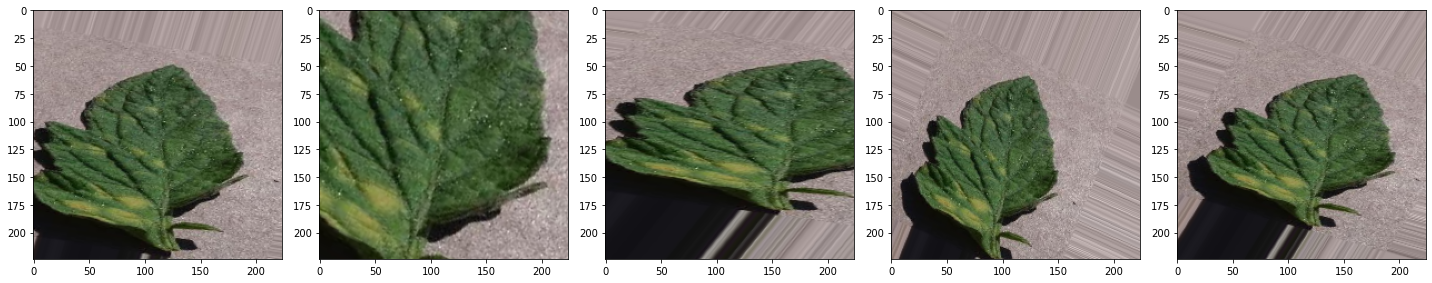

In [7]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [15]:
num_label = 10

model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dense(num_label, activation='softmax')
])

2022-07-11 14:42:46.768699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-11 14:42:46.768733: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-11 14:42:46.768764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-07-11 14:42:46.771852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [32]:
#model compiling
model.compile(optimizer=Adam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model training
history = model.fit(train_data_gen, 
    steps_per_epoch = len(train_data_gen),
    validation_data = valid_data_gen,
    validation_steps = len(valid_data_gen),
    epochs = 20, verbose = 2
)
print(history)

Epoch 1/20
100/100 - 105s - loss: 1.5895 - accuracy: 0.4505 - val_loss: 1.3316 - val_accuracy: 0.5510 - 105s/epoch - 1s/step
Epoch 2/20
100/100 - 104s - loss: 0.9694 - accuracy: 0.6658 - val_loss: 1.4869 - val_accuracy: 0.5330 - 104s/epoch - 1s/step
Epoch 3/20
100/100 - 104s - loss: 0.7811 - accuracy: 0.7333 - val_loss: 1.6182 - val_accuracy: 0.5670 - 104s/epoch - 1s/step
Epoch 4/20
100/100 - 104s - loss: 0.6727 - accuracy: 0.7714 - val_loss: 1.0021 - val_accuracy: 0.6820 - 104s/epoch - 1s/step
Epoch 5/20
100/100 - 104s - loss: 0.5908 - accuracy: 0.7951 - val_loss: 1.2018 - val_accuracy: 0.6740 - 104s/epoch - 1s/step
Epoch 6/20
100/100 - 104s - loss: 0.5362 - accuracy: 0.8139 - val_loss: 1.4430 - val_accuracy: 0.6390 - 104s/epoch - 1s/step
Epoch 7/20
100/100 - 104s - loss: 0.4828 - accuracy: 0.8333 - val_loss: 1.1530 - val_accuracy: 0.6980 - 104s/epoch - 1s/step
Epoch 8/20
100/100 - 103s - loss: 0.4473 - accuracy: 0.8474 - val_loss: 1.3278 - val_accuracy: 0.6820 - 103s/epoch - 1s/step


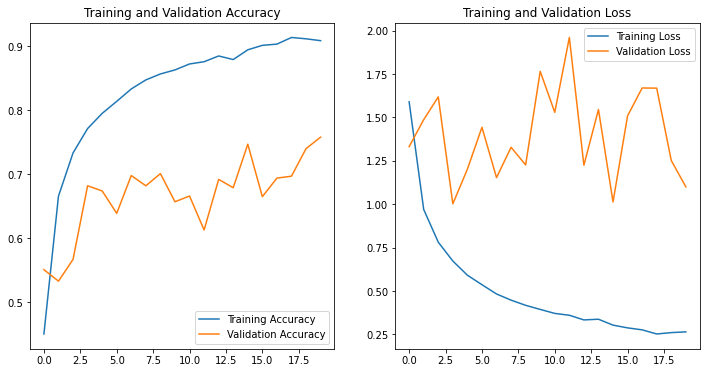

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
#valid_data_gen.classes

In [15]:
# model prediction
predictions = model.predict(x=valid_data_gen, steps=len(valid_data_gen), verbose=0)

In [16]:
np.round(predictions[0:10])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Applying Transfer Learning with Mobilenet_V2

In [16]:
#mobilenet_v2 model url
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
mobile_net = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

In [17]:
#Freezing the variables in the feature extractor layer, so that the training only modifies the final classifier layer
mobile_net.trainable = False

In [18]:
#building the transfer learning model
mobile_net_model = tf.keras.Sequential([
    mobile_net,
    Dense(10)
])

#model summary
mobile_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
#compiling the model
mobile_net_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10
history = mobile_net_model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=valid_data_gen)

Epoch 1/10
100/100 [==============================] - 253s 2s/step - loss: 1.2493 - accuracy: 0.5968 - val_loss: 0.8758 - val_accuracy: 0.7250
Epoch 2/10
100/100 [==============================] - 250s 2s/step - loss: 0.6710 - accuracy: 0.8008 - val_loss: 0.7084 - val_accuracy: 0.7690
Epoch 3/10
100/100 [==============================] - 250s 2s/step - loss: 0.5502 - accuracy: 0.8331 - val_loss: 0.6576 - val_accuracy: 0.7740
Epoch 4/10
100/100 [==============================] - 251s 2s/step - loss: 0.4853 - accuracy: 0.8498 - val_loss: 0.6147 - val_accuracy: 0.7890
Epoch 5/10
100/100 [==============================] - 251s 3s/step - loss: 0.4452 - accuracy: 0.8664 - val_loss: 0.5902 - val_accuracy: 0.7930
Epoch 6/10
100/100 [==============================] - 252s 3s/step - loss: 0.4124 - accuracy: 0.8748 - val_loss: 0.5440 - val_accuracy: 0.8050
Epoch 7/10
100/100 [==============================] - 252s 3s/step - loss: 0.3908 - accuracy: 0.8764 - val_loss: 0.5369 - val_accuracy: 0.8110

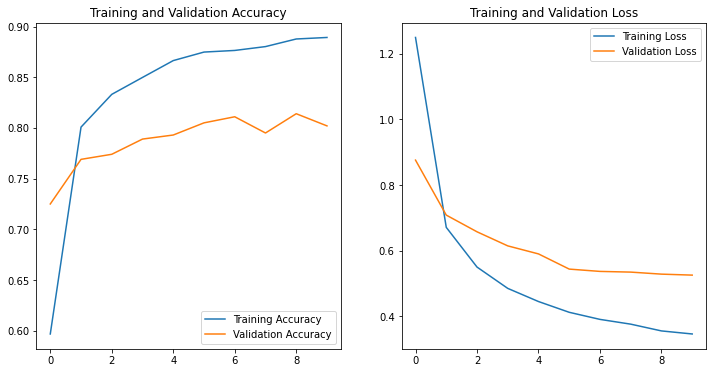

In [20]:
#ploting training vs validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Saving model

In [16]:
import pickle 
# Save the trained model as a pickle string.
pickle.dump(mobile_net_model, open('mobile_net_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://bb707a6e-a887-43f8-b3cf-1e93228868dd/assets


INFO:tensorflow:Assets written to: ram://bb707a6e-a887-43f8-b3cf-1e93228868dd/assets


In [21]:
#if model not saved to disk
import os.path
if os.path.isfile('mobile_net_model.h5') is False:
    mobile_net_model.save('mobile_net_model.h5')

In [19]:
# serialize model to json
json_model = mobile_net_model.to_json()

In [20]:
#save the model architecture to JSON file
with open('mobile_net_model.json', 'w') as json_file:
    json_file.write(json_model)

In [24]:
# #save model weights
# mobile_net_model.save_weights("weights.h5")

### Loading Saved Model and test 

In [35]:
# load json and create model
from tensorflow.keras.models import Sequential, model_from_json

json_file = open('mobile_net_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'KerasLayer':hub.KerasLayer})

# load weights into new model
loaded_model.load_weights("model_weights.h5", by_name=True)
print("Loaded model from disk")

Loaded model from disk


In [36]:
#making prediction on model
y_pred = loaded_model.predict(x=valid_data_gen, steps=len(valid_data_gen), verbose=0)

In [38]:
np.argmax(y_pred[0:10], axis=1)

array([6, 9, 3, 3, 6, 6, 3, 4, 6, 6])

In [46]:
#!pip install scikit-image

In [47]:
#function for loading image
from PIL import Image
from skimage import transform

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (IMG_SHAPE, IMG_SHAPE, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [48]:
#loading the single image
image = load('bacterial-leaf-speck-tomato-400x585.jpg')

In [49]:
#making prediction on single image
image_prediction = loaded_model.predict(image)

1/1 [==============================] - 1s 605ms/step


In [53]:
image_prediction

array([[ 0.08203724,  0.98990965, -0.60201854,  1.3466275 , -0.9008758 ,
         0.76894444,  0.94965   , -1.7392762 , -0.84812725,  0.48563024]],
      dtype=float32)

In [54]:
np.argmax(image_prediction)

3